# **Intel image classification**

*This notebook contains the code to train a Deep Learning model(CNN) to classify 6 categories of images using Transfer Learning approach with the help of Keras Pre-trained model (MobileNet V2). Kindly run this notebook on Python 3 and GPU*

### **1. Import project dependencies** 

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix

import pandas as pd
import itertools
import math

%matplotlib inline
tf.__version__

'2.4.1'

### **2. Setup dataset path** 

In [2]:
dataset_path = "/home/chaiti/Downloads/Intel_image_data"

In [3]:
train_dir = os.path.join(dataset_path, "seg_train")
test_dir = os.path.join(dataset_path, "seg_test")

### **3. Building the Model - Training a custom classifier head** 

##### 3.1 Loading the pre-trained model (MobileNetV2)

In [4]:
IMG_SHAPE = (128, 128, 3)

In [5]:
#To avoid image loading errors due to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [6]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")

##### 3.2 Freezing the base model

In [7]:
base_model.trainable = False

##### 3.3 Defining the custom head for our network

In [8]:
base_model.output

<KerasTensor: shape=(None, 4, 4, 1280) dtype=float32 (created by layer 'out_relu')>

In [9]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

In [10]:
global_average_layer

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

In [11]:
prediction_layer = tf.keras.layers.Dense(units=6, activation='softmax')(global_average_layer)

##### 3.4 Defining the model

In [12]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

In [13]:
#model.summary()

##### 3.5 Compiling the model

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss="categorical_crossentropy" , metrics=["accuracy"])

##### 3.6 Creating Data Generators

In [15]:
data_gen_train = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2, 
    rotation_range=50,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest')

data_gen_test = ImageDataGenerator(rescale=1./255)

In [16]:
# Creating Keras callbacks 
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

In [17]:
target_size_tuple = (128,128)
batch_size_test = 32

In [18]:
train_generator = data_gen_train.flow_from_directory(train_dir, target_size=target_size_tuple, batch_size=batch_size_test, class_mode="categorical" )

Found 14034 images belonging to 6 classes.


In [19]:
test_generator = data_gen_test.flow_from_directory(test_dir, target_size=target_size_tuple, batch_size=batch_size_test, class_mode="categorical")

Found 3000 images belonging to 6 classes.


In [20]:
initial_epochs = 30

In [21]:
calculate_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size_test))
steps_per_epoch = calculate_steps_per_epoch(train_generator.samples)
val_steps = calculate_steps_per_epoch(test_generator.samples)

##### 3.7 Training the model

In [22]:
history = model.fit(train_generator, steps_per_epoch= steps_per_epoch, epochs=initial_epochs, validation_data=test_generator, validation_steps=val_steps, callbacks=my_callbacks)

Epoch 1/30
439/439 [==============================] - 341s 717ms/step - loss: 1.6222 - accuracy: 0.3845 - val_loss: 0.7166 - val_accuracy: 0.7340
Epoch 2/30
439/439 [==============================] - 77s 176ms/step - loss: 0.6742 - accuracy: 0.7567 - val_loss: 0.5084 - val_accuracy: 0.8207
Epoch 3/30
439/439 [==============================] - 78s 177ms/step - loss: 0.5522 - accuracy: 0.7993 - val_loss: 0.4258 - val_accuracy: 0.8463
Epoch 4/30
439/439 [==============================] - 78s 177ms/step - loss: 0.5166 - accuracy: 0.8100 - val_loss: 0.3897 - val_accuracy: 0.8583
Epoch 5/30
439/439 [==============================] - 78s 177ms/step - loss: 0.4836 - accuracy: 0.8224 - val_loss: 0.3747 - val_accuracy: 0.8600
Epoch 6/30
439/439 [==============================] - 78s 177ms/step - loss: 0.4659 - accuracy: 0.8366 - val_loss: 0.3521 - val_accuracy: 0.8703
Epoch 7/30
439/439 [==============================] - 78s 177ms/step - loss: 0.4527 - accuracy: 0.8321 - val_loss: 0.3430 - val_a

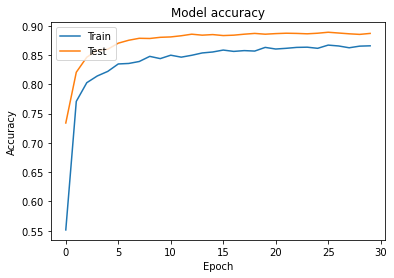

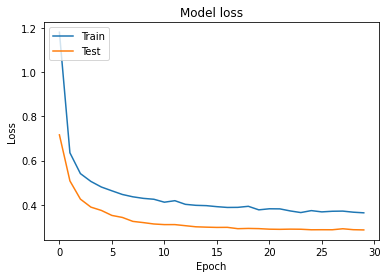

In [23]:
# Plot training & test accuracy values
acc = history.history['accuracy']
testing_acc = history.history['val_accuracy']

loss = history.history['loss']
testing_loss = history.history['val_loss']

plt.plot(acc)
plt.plot(testing_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & test loss values
plt.plot(loss)
plt.plot(testing_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


##### 3.8 Transfer learning model evaluation

In [24]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=val_steps)

94/94 [==============================] - 4s 37ms/step - loss: 0.2866 - accuracy: 0.8870


In [25]:
print("Accuracy after transfer learning: {}".format(test_accuracy))

Accuracy after transfer learning: 0.8870000243186951


### **4. Fine tuning the Model** 

##### 4.1 Un-freeze a few top layers from the model

In [26]:
base_model.trainable = True

In [27]:
print("Number of layers in the base model: {}".format(len(base_model.layers)))

Number of layers in the base model: 154


In [28]:
fine_tune_at = 100

In [29]:
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [30]:
layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_1,False
1,<tensorflow.python.keras.layers.convolutional....,Conv1,False
2,<tensorflow.python.keras.layers.normalization_...,bn_Conv1,False
3,<tensorflow.python.keras.layers.advanced_activ...,Conv1_relu,False
4,<tensorflow.python.keras.layers.convolutional....,expanded_conv_depthwise,False
...,...,...,...
149,<tensorflow.python.keras.layers.convolutional....,block_16_project,True
150,<tensorflow.python.keras.layers.normalization_...,block_16_project_BN,True
151,<tensorflow.python.keras.layers.convolutional....,Conv_1,True
152,<tensorflow.python.keras.layers.normalization_...,Conv_1_bn,True


##### 4.2 Compiling the model for fine-tuning

In [31]:
data_gen_train = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2, 
    rotation_range=50,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest')

data_gen_test = ImageDataGenerator(rescale=1./255)

In [32]:
# Creating Keras callbacks 
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

In [33]:
target_size_tuple = (128,128)
batch_size_test = 32

In [34]:
train_generator = data_gen_train.flow_from_directory(train_dir, target_size=target_size_tuple, batch_size=batch_size_test, class_mode="categorical" )

Found 14034 images belonging to 6 classes.


In [35]:
test_generator = data_gen_test.flow_from_directory(test_dir, target_size=target_size_tuple, batch_size=batch_size_test, class_mode="categorical")

Found 3000 images belonging to 6 classes.


In [36]:
calculate_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size_test))
steps_per_epoch = calculate_steps_per_epoch(train_generator.samples)
val_steps = calculate_steps_per_epoch(test_generator.samples)

In [37]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
fine_tune_epochs = 30
total_epochs = initial_epochs+fine_tune_epochs

##### 4.3 Fine tuning

In [39]:
history_fine = model.fit(train_generator, steps_per_epoch= steps_per_epoch, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=test_generator, validation_steps=val_steps, callbacks=my_callbacks )

Epoch 30/60
439/439 [==============================] - 92s 189ms/step - loss: 0.9082 - accuracy: 0.6838 - val_loss: 0.3917 - val_accuracy: 0.8497
Epoch 31/60
439/439 [==============================] - 77s 175ms/step - loss: 0.4888 - accuracy: 0.8220 - val_loss: 0.3126 - val_accuracy: 0.8807
Epoch 32/60
439/439 [==============================] - 77s 175ms/step - loss: 0.4459 - accuracy: 0.8345 - val_loss: 0.2914 - val_accuracy: 0.8877
Epoch 33/60
439/439 [==============================] - 77s 175ms/step - loss: 0.4030 - accuracy: 0.8489 - val_loss: 0.2813 - val_accuracy: 0.8933
Epoch 34/60
439/439 [==============================] - 77s 175ms/step - loss: 0.3980 - accuracy: 0.8585 - val_loss: 0.2801 - val_accuracy: 0.8927
Epoch 35/60
439/439 [==============================] - 77s 174ms/step - loss: 0.3633 - accuracy: 0.8666 - val_loss: 0.2809 - val_accuracy: 0.8943
Epoch 36/60
439/439 [==============================] - 77s 175ms/step - loss: 0.3573 - accuracy: 0.8674 - val_loss: 0.2767 -

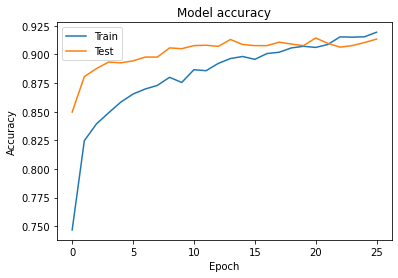

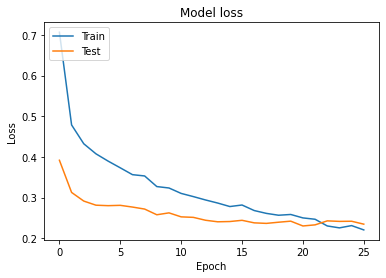

In [40]:
# Plot training & test accuracy values
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & test loss values
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


##### 4.4 Evaluating the fine tuned model

In [41]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=val_steps)

94/94 [==============================] - 4s 37ms/step - loss: 0.2346 - accuracy: 0.9133


In [42]:
print("test accuracy after fine tuning: {}".format(test_accuracy))

test accuracy after fine tuning: 0.9133333563804626


#####  4.5 Performance evaluation on test dataset: Classification report and confusion matrix

In [43]:
#Performance evaluation setup to plot confusion  matrix and output classification report
test_data_gen_no_shuffle = data_gen_test.flow_from_directory(test_dir, target_size=target_size_tuple, batch_size=batch_size_test, class_mode="categorical", shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_gen_no_shuffle.samples / test_data_gen_no_shuffle.batch_size)
predictions = model.predict_generator(test_data_gen_no_shuffle, steps=test_steps_per_epoch)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data_gen_no_shuffle.classes
class_labels = list(test_data_gen_no_shuffle.class_indices.keys())

target_names = ['buildings',
'forest',
'glacier',
'mountain',
'sea',
'street',
]

#Print classification report
print('Classification Report')
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

Found 3000 images belonging to 6 classes.
Classification Report
              precision    recall  f1-score   support

   buildings       0.91      0.91      0.91       437
      forest       1.00      1.00      1.00       474
     glacier       0.82      0.90      0.86       553
    mountain       0.90      0.79      0.84       525
         sea       0.94      0.95      0.95       510
      street       0.93      0.94      0.93       501

    accuracy                           0.91      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.91      0.91      0.91      3000



Normalized confusion matrix


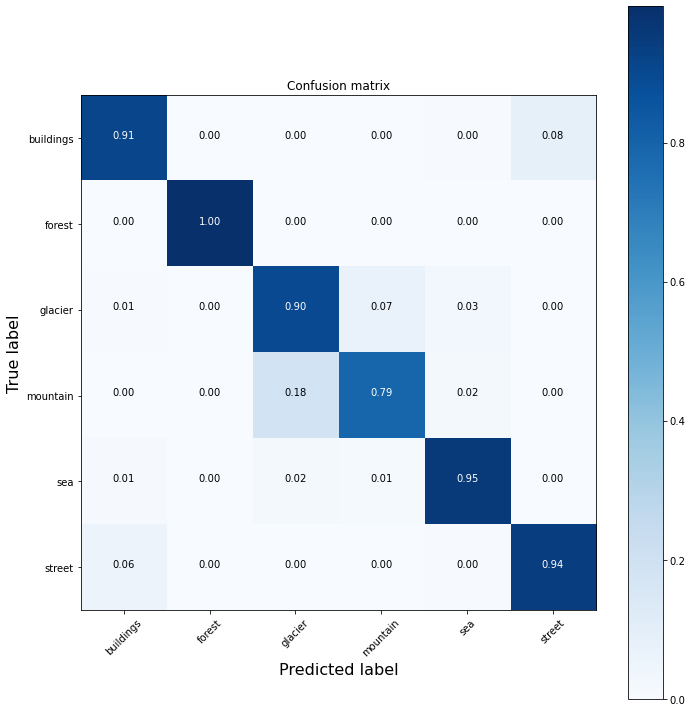

In [44]:
#Plot confusion matrix
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
 

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    figure = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0])
                               ,range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    figure.savefig("/home/chaiti/Downloads/conf_matrix_norm.pdf", bbox_inches='tight')
    

conf_mat = (confusion_matrix(true_classes, predicted_classes))    
plot_confusion_matrix(conf_mat, target_names , normalize = True)

Confusion matrix, without normalization


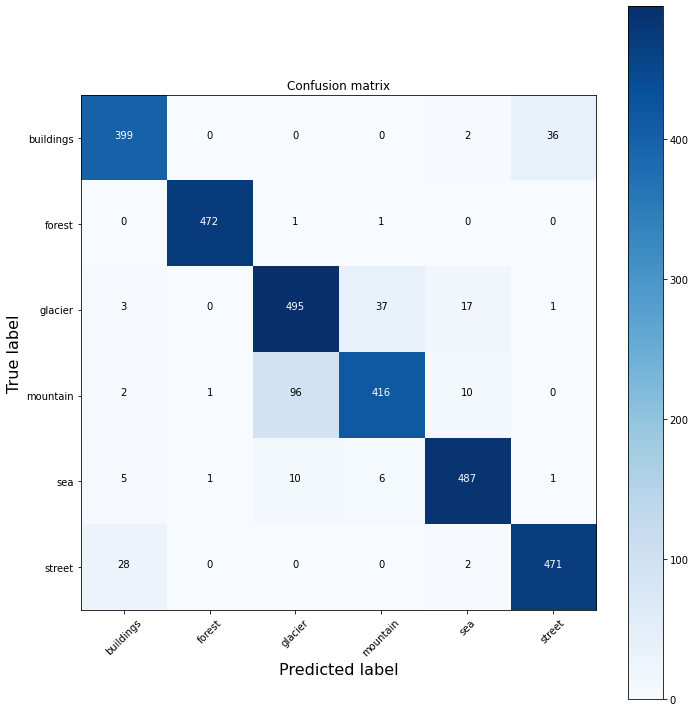

In [45]:
#Plot confusion matrix
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
 

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    figure = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0])
                               ,range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label',fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    figure.savefig("/home/chaiti/Downloads/conf_matrix_without_norm_9.pdf", bbox_inches='tight')
    

conf_mat = (confusion_matrix(true_classes, predicted_classes))    
plot_confusion_matrix(conf_mat, target_names , normalize = False)

#### **4.6. Save the Keras Model** 

In [46]:
#Save model as .h5 keras model
keras_model = model.save('/home/chaiti/Downloads/Intel_image_classify_model.h5')

### **5. Load the saved model and perform predictions on new test image**

##### 5.1 Load the model

In [47]:
#Load the model
model_pred = tf.keras.models.load_model('/home/chaiti/Downloads/Intel_image_classify_model.h5')

In [48]:
#Import the module dependencies
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image as img
from tensorflow.keras.preprocessing.image import img_to_array, load_img

##### 5.2 Load the test image

(128, 128, 3)


Text(0.5, 1.0, '/home/chaiti/Downloads/Intel_image_data/seg_pred/5.jpg')

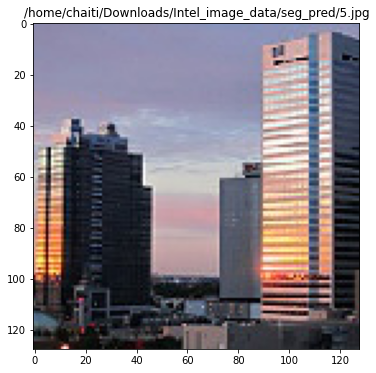

In [49]:
#Load the test image and display
target_size = (128, 128)
img_path = '/home/chaiti/Downloads/Intel_image_data/seg_pred/5.jpg'
plt.figure(figsize=(6, 6))
img_array = img_to_array(load_img(img_path, target_size=target_size)) / 255.
print(img_array.shape)
plt.imshow(img_array)
plt.title(img_path)

#### 5.3 Preprocess image and print top-k predictions

In [50]:
#Perform preprocessing and prediction
image = img.load_img(img_path,target_size=target_size)
x = img_to_array(image)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model_pred.predict(x)

In [51]:
#Fetch top k predictions
num_labels = 6
top_k = 3

pred_sort = np.argsort(preds, axis=1)[:,-num_labels:]
pred_top_k = pred_sort[0][-top_k:]
pred_top_k_sort = pred_top_k[::-1]
pred_top_k_sort_list = pred_top_k_sort.tolist()

In [52]:
#Create dictionary of key=label index, value=[label name, prediction probabilities]
labels= [0,1,2,3,4,5]
species = target_names
prediction_dict = {}

for i in pred_top_k_sort_list:
    prediction_dict[i] = [species[i],'{:0.10f}'.format(preds[0][i])]

#Print k-top predictions
print(prediction_dict)

{0: ['buildings', '0.9717729092'], 5: ['street', '0.0277074650'], 4: ['sea', '0.0005113648']}


### 6. Model optimization and Compression - Convert Keras .h5 to .tflite

#### 6.1 Non-quantized conversion

In [53]:
#Convert keras model to tflite model (non-quantized)
#Upgrade to TF2 if TF1 doesnt work
new_model = tf.keras.models.load_model('/home/chaiti/Downloads/Intel_image_classify_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()
open("/home/chaiti/Downloads/non_quantized_converted_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp4129ny3j/assets


8889172

#### 6.2 Post training quantization- Float16 

In [54]:
#Convert keras model to tflite model (quantized- float16 quantization)
new_model = tf.keras.models.load_model('/home/chaiti/Downloads/Intel_image_classify_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()
open("/home/chaiti/Downloads/float16_quantized_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp5q86qy6j/assets


INFO:tensorflow:Assets written to: /tmp/tmp5q86qy6j/assets


4476704

#### 6.3 Post training quantization- Dynamic range 

In [55]:
#Convert keras model to tflite model (quantized - dynamic quantization)
new_model = tf.keras.models.load_model('/home/chaiti/Downloads/Intel_image_classify_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
open("/home/chaiti/Downloads/dynamic_range_quantized_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpbc10um7j/assets


INFO:tensorflow:Assets written to: /tmp/tmpbc10um7j/assets


2645600

#### 6.4 Evaluate converted - model non-quantized, float16, dynamic range 

In [56]:
#Modify batchsize to total number of images in test set in test_generator to get actual accuracy over all test data 
batch_size = 3000
test_generator = data_gen_test.flow_from_directory(test_dir, target_size=target_size_tuple, batch_size=batch_size, class_mode="categorical")

Found 3000 images belonging to 6 classes.


In [57]:
batch_images, batch_labels = next(test_generator)
print(batch_images.shape)

(3000, 128, 128, 3)


In [58]:
#Non-quantized compressed model accuracy
def set_input_tensor(interpreter, input):
  input_index = interpreter.get_input_details()[0]["index"]
  test_img = np.expand_dims(input, axis=0).astype(np.float32)
  interpreter.set_tensor(input_index, test_img)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_index = interpreter.get_output_details()[0]["index"]
  output = interpreter.tensor(output_index)
  top_1 = np.argmax(output()[0])
  return top_1

interpreter = tf.lite.Interpreter(model_path=str('/home/chaiti/Downloads/non_quantized_converted_model.tflite'))
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)
#print(batch_truth)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)
#print(batch_prediction)
# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Non Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))

Non Quant TF Lite accuracy: 91.333%


In [59]:
#Float16-quantized and compressed model accuracy
def set_input_tensor(interpreter, input):
  input_index = interpreter.get_input_details()[0]["index"]
  test_img = np.expand_dims(input, axis=0).astype(np.float32)
  interpreter.set_tensor(input_index, test_img)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_index = interpreter.get_output_details()[0]["index"]
  output = interpreter.tensor(output_index)
  top_1 = np.argmax(output()[0])
  return top_1

interpreter = tf.lite.Interpreter(model_path=str('/home/chaiti/Downloads/float16_quantized_model.tflite'))
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)
#print(batch_truth)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)
#print(batch_prediction)
# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant Float16 TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))

Quant Float16 TF Lite accuracy: 91.267%


In [60]:
#Dynamic range quantized and compressed model accuracy
def set_input_tensor(interpreter, input):
  input_index = interpreter.get_input_details()[0]["index"]
  test_img = np.expand_dims(input, axis=0).astype(np.float32)
  interpreter.set_tensor(input_index, test_img)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_index = interpreter.get_output_details()[0]["index"]
  output = interpreter.tensor(output_index)
  top_1 = np.argmax(output()[0])
  return top_1

interpreter = tf.lite.Interpreter(model_path=str('/home/chaiti/Downloads/dynamic_range_quantized_model.tflite'))
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)
#print(batch_truth)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)
#print(batch_prediction)
# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant Dynamic range TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))

Quant Dynamic range TF Lite accuracy: 89.900%
